In [15]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForAudioClassification, AutoFeatureExtractor
from torch.optim import AdamW


# ==== STEP 1: Dataset Directory ====
dataset_dirs = {
    "norm": "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm",
}

mel_transform = T.MelSpectrogram(sample_rate=32000, n_fft=1024, hop_length=320, n_mels=128)

In [17]:
# def preprocess_audio(file_path, duration=2.0, sr=32000):
#     waveform, _ = torchaudio.load(file_path)
#     waveform = waveform[:, :int(sr * duration)]
#     if waveform.shape[1] < int(sr * duration):
#         waveform = torch.nn.functional.pad(waveform, (0, int(sr * duration) - waveform.shape[1]))
#     mel_spec = mel_transform(waveform)
#     log_mel = torch.log(mel_spec + 1e-9)
#     return log_mel

# def plot_log_mel(log_mel, title="Log-Mel Spectrogram"):
#     plt.figure(figsize=(10, 4))
#     plt.imshow(log_mel.squeeze().numpy(), aspect='auto', origin='lower', cmap='magma')
#     plt.title(title)
#     plt.xlabel("Time")
#     plt.ylabel("Mel Frequency")
#     plt.colorbar(label="Log Amplitude")
#     plt.tight_layout()
#     plt.show()
    
# log_mel = preprocess_audio("example.wav")  # Provide your own file path
# plot_log_mel(log_mel)


In [18]:


# ==== STEP 3: Load and Label Audio Files ====
def load_and_label_audio(data_dir):
    files, labels = [], []
    for label in ['real', 'fake']:
        folder = os.path.join(data_dir, label)
        for fname in os.listdir(folder):
            if fname.endswith('.wav'):
                files.append(os.path.join(folder, fname))
                labels.append(0 if label == 'real' else 1)
    return files, labels


In [19]:
# def safe_collate(batch):
#     # Remove all None items
#     batch = [item for item in batch if item is not None]
#     if len(batch) == 0:
#         return None  # Avoid batch of only corrupted data
#     return torch.utils.data.dataloader.default_collate(batch)


def safe_collate(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None

    inputs, labels = zip(*batch)
    max_len = max([x.shape[-1] for x in inputs])

    padded_inputs = [
        F.pad(x, (0, max_len - x.shape[-1])) for x in inputs
    ]

    return torch.stack(padded_inputs), torch.tensor(labels)


In [20]:
#Yet to be tried

from torch.utils.data import Dataset
import torchaudio
import torch.nn.functional as F
import torch
import random


def add_noise(waveform, noise_level=0.005):
    noise = noise_level * torch.randn_like(waveform)
    return waveform + noise

def time_stretch(waveform, rate_range=(0.8, 1.2)):
    rate = random.uniform(*rate_range)
    stretch = torchaudio.transforms.TimeStretch(hop_length=512, n_freq=waveform.shape[0])
    complex_spec = torch.stft(waveform, n_fft=1024, hop_length=512, return_complex=True)
    stretched = stretch(complex_spec, rate)
    return torch.istft(stretched, n_fft=1024, hop_length=512)

def preprocess_waveform(waveform, sr, target_sr=32000, duration=2.0, apply_noise=True, apply_stretch=True, fixed_frames=224):
    if sr != target_sr:
        resample = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)
        waveform = resample(waveform)
        sr = target_sr

    num_samples = int(duration * sr)
    if waveform.shape[1] > num_samples:
        waveform = waveform[:, :num_samples]
    elif waveform.shape[1] < num_samples:
        padding = num_samples - waveform.shape[1]
        waveform = F.pad(waveform, (0, padding))

    if apply_stretch:
        try:
            waveform = time_stretch(waveform)
        except Exception as e:
            print("Time-stretch failed:", e)
    if apply_noise:
        waveform = add_noise(waveform)

    mel_spec = mel_transform(waveform)
    log_mel = torch.log(mel_spec + 1e-9)

    # Ensure fixed number of frames
    if log_mel.shape[-1] > fixed_frames:
        log_mel = log_mel[:, :, :fixed_frames]
    elif log_mel.shape[-1] < fixed_frames:
        pad_amount = fixed_frames - log_mel.shape[-1]
        log_mel = F.pad(log_mel, (0, pad_amount))

    return log_mel


class FakeSpeechDataset(Dataset):
    def __init__(self, files, labels, duration=2.0, sample_rate=32000, augment=True):
        self.files = files
        self.labels = labels
        self.duration = duration
        self.sample_rate = sample_rate
        self.augment = augment

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            waveform, sr = torchaudio.load(self.files[idx])
            log_mel = preprocess_waveform(
                waveform, sr,
                target_sr=self.sample_rate,
                duration=self.duration,
                apply_noise=self.augment,
                apply_stretch=self.augment
            )
            label = torch.tensor(self.labels[idx])
            return log_mel, label
        except Exception as e:
            print(f"Skipping index {idx} due to error: {e}")
            return None  # Use custom collate_fn to filter out


In [21]:
data_dir = dataset_dirs['norm']
num_epochs = 5
batch_size = 16

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load file paths and labels
train_files, train_labels = load_and_label_audio(os.path.join(data_dir, 'training'))
val_files, val_labels = load_and_label_audio(os.path.join(data_dir, 'validation'))
test_files, test_labels = load_and_label_audio(os.path.join(data_dir, 'testing'))



In [23]:
##Restrict to the first n samples for each dataset

n_smpl=1000

count_0 = train_labels.count(0)
count_1 = train_labels.count(1)

train_files, train_labels = train_files[count_0-n_smpl: count_1+n_smpl], train_labels[count_0-n_smpl: count_1+n_smpl]

count_0 = val_labels.count(0)
count_1 = val_labels.count(1)

val_files, val_labels = val_files[count_0-n_smpl: count_1+n_smpl], val_labels[count_0-n_smpl: count_1+n_smpl]

count_0 = test_labels.count(0)
count_1 = test_labels.count(1)

test_files, test_labels = test_files[count_0-n_smpl: count_1+n_smpl], test_labels[count_0-n_smpl: count_1+n_smpl]

In [24]:
# Create datasets and loaders
train_dataset = FakeSpeechDataset(train_files, train_labels)


val_dataset = FakeSpeechDataset(val_files, val_labels)

test_dataset = FakeSpeechDataset(test_files, test_labels)



train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=safe_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=safe_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=safe_collate)

In [25]:
!pip install hear21passt

In [26]:
# Load model
from hear21passt.base import get_basic_model,get_model_passt
import torch

model = get_basic_model(mode="logits")
# print(model.mel) # Extracts mel spectrogram from raw waveforms.




 Loading PASST TRAINED ON AUDISET 


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), ep

In [27]:

model.net = get_model_passt(arch="passt_s_swa_p16_128_ap476", n_classes=2)
# print(model.net) # the transformer network.

model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-4)



 Loading PASST TRAINED ON AUDISET 


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), ep

In [28]:
from tqdm import tqdm

# Track losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]", leave=False)

    for log_mel, label in train_bar:
        if log_mel is None:
            continue
        log_mel = log_mel.to(device)  # Shape: [B, 1, 128, 224]
        label = label.to(device)

        outputs = model.net(log_mel)[0]  # Select the first element of the tuple
       

        loss = F.cross_entropy(outputs, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    train_losses.append(total_train_loss)

    # Validation loop
    model.eval()
    total_val_loss = 0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]", leave=False)

    with torch.no_grad():
        for log_mel, label in val_bar:
            if log_mel is None:
                continue
            log_mel, label = log_mel.to(device), label.to(device)

            outputs = model.net(log_mel)[0]  # Use model.net directly abc
            loss = F.cross_entropy(outputs, label)
            total_val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())

    val_losses.append(total_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}")


Epoch 1, Train Loss: 53.2357, Val Loss: 35.9864


Epoch 2, Train Loss: 29.2394, Val Loss: 21.5435


Epoch 3, Train Loss: 23.9729, Val Loss: 21.2868


Epoch 4, Train Loss: 17.8964, Val Loss: 15.5096


Epoch 5, Train Loss: 16.8427, Val Loss: 19.5153


In [29]:
from sklearn.metrics import accuracy_score, f1_score

# Initialize lists to store predictions and labels for the test set
all_preds, all_labels = [], []

# Set model to evaluation mode
model.eval()

# Disable gradient calculations to speed up inference
with torch.no_grad():
    test_bar = tqdm(test_loader, desc="Test [Evaluation]", leave=False)

    for log_mel, label in test_bar:
        if log_mel is None:
            continue
        log_mel, label = log_mel.to(device), label.to(device)

        # Pass the input through the model and get outputs
        outputs = model.net(log_mel)[0]  # Access the first element of the output tuple

        # Get predictions from the outputs (using argmax for classification)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Store predictions and labels
        all_preds.extend(preds)
        all_labels.extend(label.cpu().numpy())  # Convert labels to numpy array if necessary



# After processing all test data, calculate accuracy and F1 score
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')  # Use average='micro', 'macro', or 'weighted'

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Test Accuracy: 0.7896
Test F1 Score: 0.7817


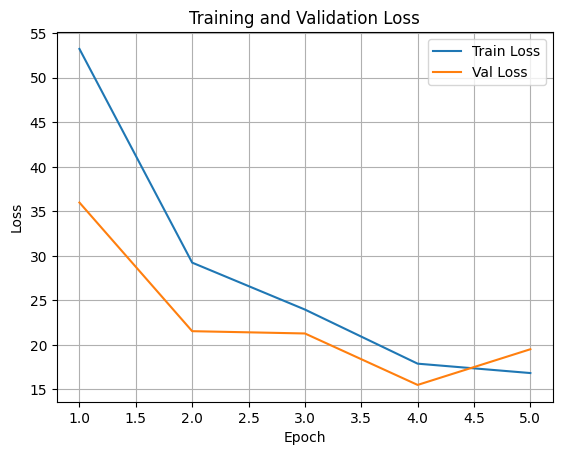

In [30]:


# Plot losses
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


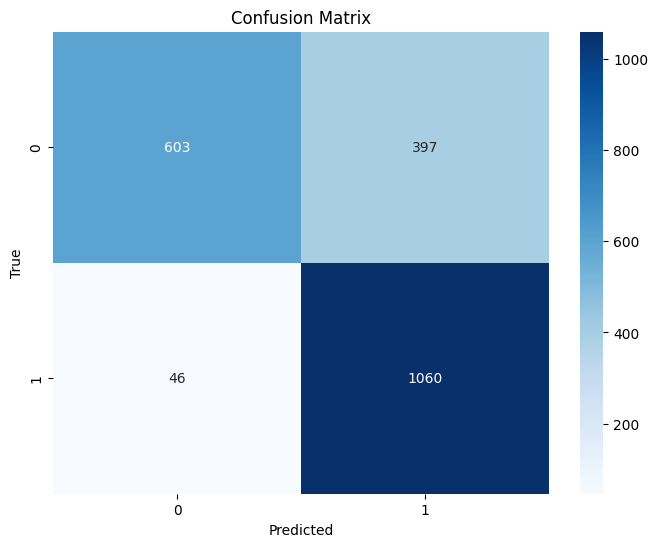

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
torch.save(model.state_dict(), "/kaggle/working/passt_weights.pth")
